In [40]:
%matplotlib widget
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import numpy as np
import collections
import glob
import os
import sys 
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
sys.path.insert(0, '../dip_utils')
from matrix_utils import arr_info
from vis_utils import (vis_pair, 
                       vis_triple)
%run watershed.ipynb
%run calibrate.ipynb
%run greyscale.ipynb
%run image_stacking.ipynb
%run whitep_elimination.ipynb

In [43]:
path = '../test_images/'
dest = '../stacked_test/'
clear = '../stacked_new/NTU0.jpg'

In [3]:
%%bash
cd ../stacked_test/
rm -r *

bash: line 1: cd: ../stacked_test/: No such file or directory


In [44]:
image_stacking(path, dest)

In [47]:
image = []
filename = []
for dic in os.listdir(dest):
    if dic != '.ipynb_checkpoints':
        filename.append(dic)
for dic in os.listdir(dest):
    d = os.path.join(dest, dic)  # directory of water samples
    if not d.endswith('.ipynb_checkpoints'):
        img = plt.imread(d)
        image.append(img)

In [48]:
img_lib = {}
for i in range(len(filename)):
    img_lib[filename[i]] = image[i]

In [49]:
markers_lib = dict()
for img in img_lib:
    markers = watershed(dest, img)
    markers_lib[img] = markers

In [50]:
bottom_lib = dict()
left_lib = dict()

In [51]:
# Acquire the bottom and the leftmost point of the ROI
for key in markers_lib:
    bottom = np.where(markers_lib[key]==1)[0].max()
    bottom_lib[key] = bottom
    left = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].min()
    left_lib[key] = left

In [52]:
# Some threshold values
vert_thres = 550
horz_thres = 50
length = 80
dist = 350

In [53]:
# Avoid Extracting incorrect ROI
for key in markers_lib:
    while markers_lib[key][bottom_lib[key]-vert_thres, left_lib[key]+horz_thres] == 1:
        left_lib[key] += horz_thres
left_lib

{'NTU323.jpg': 131,
 'NTU108.jpg': 199,
 'NTU214.jpg': 224,
 'NTU417.jpg': 183,
 'NTU185.jpg': 247,
 'NTU35_2.jpg': 230,
 'NTU74_5.jpg': 260,
 'NTU148.jpg': 209,
 'NTU263.jpg': 228,
 'NTU160.jpg': 166,
 'NTU374.jpg': 208,
 'NTU235.jpg': 194,
 'NTU43_3.jpg': 176,
 'NTU65_3.jpg': 119,
 'NTU296.jpg': 184,
 'NTU50_5.jpg': 210,
 'NTU358.jpg': 121,
 'NTU137.jpg': 180,
 'NTU127.jpg': 74,
 'NTU334.jpg': 241,
 'NTU164.jpg': 192}

In [54]:
# Calibration
calibrated = {}
for img in img_lib:
    org = plt.imread(os.path.join(dest, img))
    org = lab_trans(clear, org)
    calibrated[img] = org

In [55]:
greyscale = {}
for img in img_lib:
    grey = calibrated[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [56]:
# x_left represents the ROI of the reference, while x_right represents the ROI of the sample
x_left = []
x_right = []
y_left = []
y_right = []

In [57]:
for key in greyscale:
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(bottom_lib[key], bottom_lib[key]-vert_thres, -1):
        x.append(i)
        y.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_thres:left_lib[key]+horz_thres+length]))
    x_left.append(x)
    y_left.append(y)
    for i in range(bottom_lib[key], bottom_lib[key]-vert_thres, -1):
        x1.append(i)
        y1.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_thres+dist:
                                         left_lib[key]+horz_thres+dist+length]))
    x_right.append(x1)
    y_right.append(y1)

In [58]:
left_lib[key]+horz_thres+dist, left_lib[key]+horz_thres+dist+length

(592, 672)

In [59]:
x_left = np.array(x_left)
x_right = np.array(x_right)
y_left = np.array(y_left)
y_right = np.array(y_right)

In [60]:
# plot the ratio with respect to NTU
num = []
for img in img_lib:
    img = img.replace('_', '.')
    a = img.split('NTU')
    a = [b.split('.jpg') for b in a]
    for item in a:
        item.remove("")
    num.append(a)

In [61]:
NTU = []
for i in num:
    for j in i:
        if len(j) != 0:
            NTU.append(float(j[0]))

In [62]:
f = open('../assets/theta.txt')
thresholds = f.readlines()
for i in range(len(thresholds)):
    thresholds[i] = thresholds[i].strip()
    thresholds[i] = float(thresholds[i])

In [63]:
diff = []
for i in range(x_left.shape[0]):
    diff.append(np.mean(y_right[i] - y_left[i]))

In [64]:
for i in range(len(diff)):
    diff[i] -= thresholds[0]

In [65]:
correction = abs(thresholds[2] / thresholds[1])
correction

4.596875420451257

In [66]:
estimated = [round(diff[i]*thresholds[1]+thresholds[2], 2) for i in range(len(diff))]

In [67]:
pair = dict(zip(NTU, estimated))

In [68]:
od_NTU = []
od_estimated = []
for key, value in sorted(pair.items()):
    od_NTU.append(key)
    od_estimated.append(value)

In [69]:
r2 = r2_score(od_NTU, od_estimated)
r2 = round(r2, 3)

In [84]:
df = pd.DataFrame(list(zip(od_NTU, od_estimated)),
               columns =['Actual_NTU', 'Estimated_NTU'])

In [85]:
df['R^2'] = r2
df

,Actual_NTU,Estimated_NTU,R^2
0,35.2,101.07,0.945
1,43.3,56.42,0.945
2,50.5,73.07,0.945
3,65.3,86.56,0.945
4,74.5,94.96,0.945
5,108.0,127.13,0.945
6,127.0,78.13,0.945
7,137.0,174.04,0.945
8,148.0,173.45,0.945
9,160.0,162.77,0.945


In [86]:
df.to_csv('../assets/prediction.csv')

In [87]:
# Figure 10
model = ols('Estimated_NTU ~ Actual_NTU', data=df).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Estimated_NTU   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     393.5
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           3.69e-14
Time:                        11:54:56   Log-Likelihood:                -95.766
No. Observations:                  21   AIC:                             195.5
Df Residuals:                      19   BIC:                             197.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0537     10.432      2.593      0.0

eval_env: 1


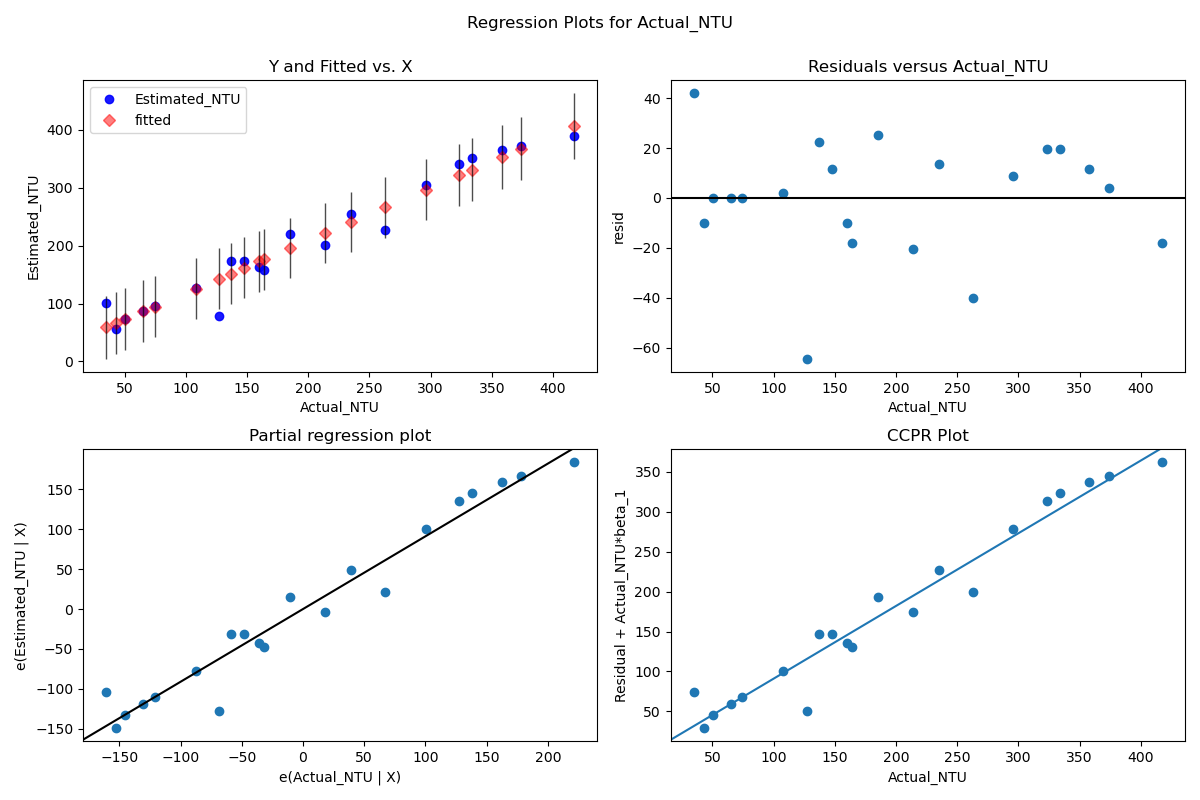

In [89]:
# Figure 9
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'Actual_NTU', fig=fig)
plt.savefig('test_fit.pdf', dpi=600)
plt.show()